# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [4]:
max_time = 60 * 15 # 15min

In [5]:
import time

In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)

In [7]:
import utils.presenter as show
import utils.checker as check

import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [8]:
import utils.scheduling_solver as ssv

In [9]:
df_instance= pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 1, u_b_mmax= 0.98)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
185,Job_018,5,M9,76
186,Job_018,6,M5,47
187,Job_018,7,M3,52
188,Job_018,8,M4,90


In [10]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=0.95, buffer_factor=1)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,681
1,Job_001,80.87,960
2,Job_002,140.32,1119
3,Job_003,191.00,1320
4,Job_004,226.49,904
...,...,...,...
14,Job_014,1093.73,2223
15,Job_015,1099.60,1777
16,Job_016,1100.92,2080
17,Job_017,1216.01,1897


In [11]:
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,0,681
1,Job_001,80,960
2,Job_002,140,1119
3,Job_003,191,1320
4,Job_004,226,904
...,...,...,...
14,Job_014,1093,2223
15,Job_015,1099,1777
16,Job_016,1100,2080
17,Job_017,1216,1897


## a) Summe der absoluten Lateness je Job (letze Operation)

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [66]:
from ortools.sat.python import cp_model
import pandas as pd

def solve_cp_jssp_sum_absolute_lateness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, 
                                        sort_ascending: bool = False, msg: bool = False,
                                        timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sortiere nach Deadline, falls gewünscht
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Gruppiere Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # Variablen definieren
    starts, ends, intervals = {}, {}, {}
    abs_lateness_vars = []

    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o, (op_id, m, d) in enumerate(seq):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Lateness-Berechnung und Nebenbedingungen pro Job
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]

        # Lateness kann positiv (zu spät) oder negativ (zu früh) sein
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        abs_lateness = model.NewIntVar(0, horizon, f"abs_lateness_{j}")
        model.Add(lateness == job_end - deadline[job])
        model.AddAbsEquality(abs_lateness, lateness)
        abs_lateness_vars.append(abs_lateness)

        # Arrival-Bedingung
        model.Add(starts[(j, 0)] >= arrival[job])

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # Maschinenrestriktionen
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion
    model.Minimize(sum(abs_lateness_vars))

    # Solver starten
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel

    status = solver.Solve(model)

    # Lösung extrahieren (nur bei OPTIMAL oder FEASIBLE)
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness,
                    "Absolute Lateness": abs(lateness)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # Logging
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Summe Absolute Lateness : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound    : {solver.BestObjectiveBound()}")
    print(f"Laufzeit                : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [68]:
starting_time = time.time()

# Scheduling
df_plan_sum_l = solve_cp_jssp_sum_absolute_lateness(df_jssp, df_times, msg=False, timeLimit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_l


Solver-Status         : OPTIMAL
Summe Absolute Lateness : 31.0
Best Objective Bound    : 31.0
Laufzeit                : 22.87 Sekunden

Scheduling-Dauer: 0 Minuten und 22.88 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0,681,M0,0,29,29,-652,652
1,Job_000,1,0,681,M1,29,78,107,-574,574
2,Job_001,0,80,960,M0,80,43,123,-837,837
3,Job_000,2,0,681,M2,107,9,116,-565,565
4,Job_000,3,0,681,M3,116,36,152,-529,529
...,...,...,...,...,...,...,...,...,...,...
185,Job_014,7,1093,2223,M3,2056,98,2154,-69,69
186,Job_018,8,1312,2244,M4,2080,90,2170,-74,74
187,Job_014,8,1093,2223,M9,2154,22,2176,-47,47
188,Job_014,9,1093,2223,M5,2180,43,2223,0,0


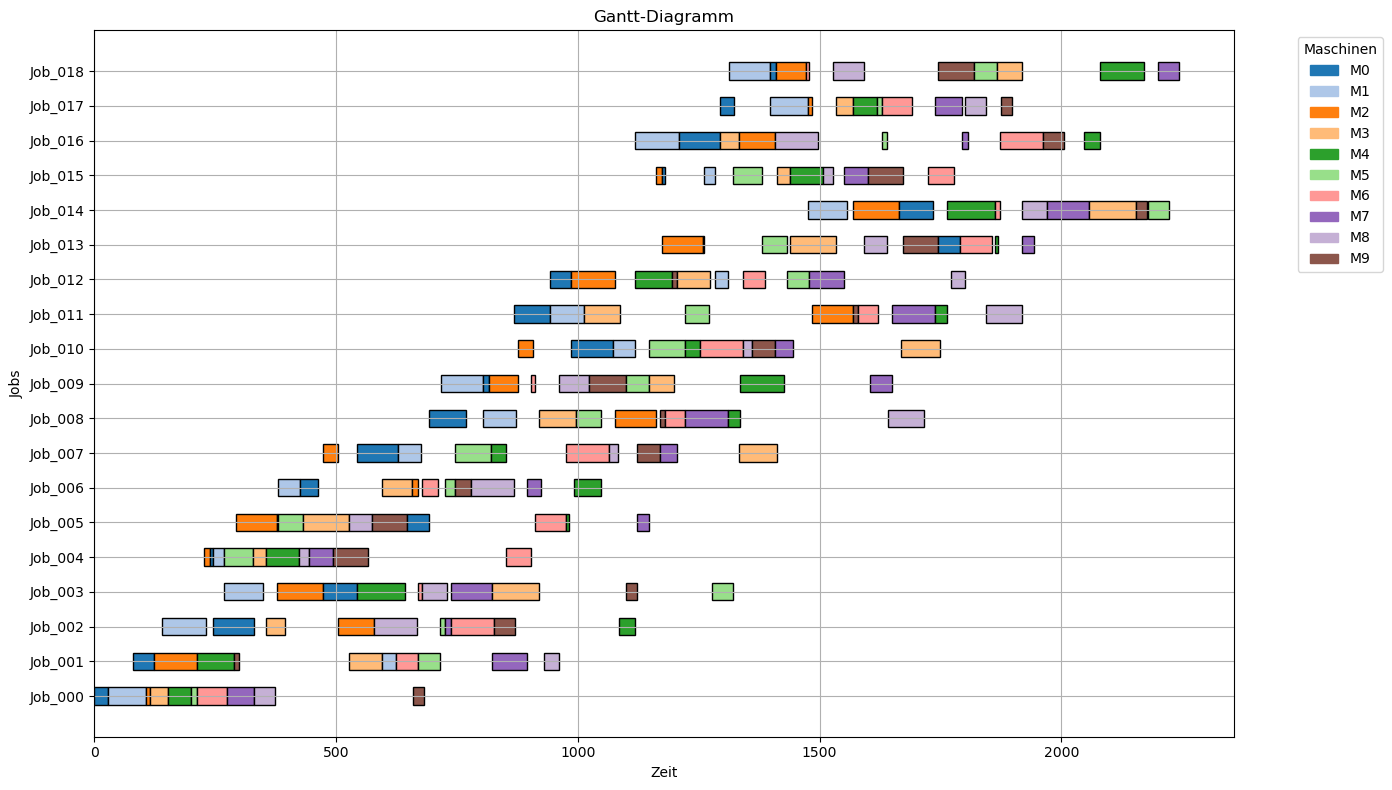

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [69]:
df_plan = df_plan_sum_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [70]:
last_ops = df_plan_sum_l.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, 'Lateness', min_val = 0, max_val=60, steps=10)

label
<-60          0
-60 - -50     0
-50 - -40     0
-40 - -30     0
-30 - -20     0
-20 - -10     0
-10 - 0       0
0            17
0 - 10        1
10 - 20       0
20 - 30       1
30 - 40       0
40 - 50       0
50 - 60       0
>60           0
Name: count, dtype: int32

## b) Summe der Lateness minimieren (gewichtet Tardiness und Earliness)

### Zielfunktion

$$
\min \sum_{j \in J} \left( w_t \cdot \max(C_j - d_j,\ 0) + w_e \cdot \max(d_j - C_j,\ 0) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) des letzten Arbeitsschritts von Job $j$  
- $d_j$: Deadline (Soll-Endzeitpunkt) von Job $j$  
- $w_t$: Gewichtung der **Tardiness** (Verspätung)  
- $w_e$: Gewichtung der **Earliness** (Frühfertigkeit)  
- $\max(C_j - d_j,\ 0)$: positive Verspätung  
- $\max(d_j - C_j,\ 0)$: positive Frühfertigkeit  

### Erklärung

Diese Zielfunktion minimiert die gewichtete Summe aus **Tardiness** (Verspätung) und **Earliness** (Frühfertigkeit) aller Jobs.  
Dabei wird jede Abweichung zur Deadline einzeln bewertet:

- **Tardiness** wird mit $w_t$ gewichtet und tritt auf, wenn ein Job **nach** seiner Deadline fertig wird.
- **Earliness** wird mit $w_e$ gewichtet und tritt auf, wenn ein Job **vor** seiner Deadline fertig wird.

Durch die Wahl von $w_t \gg w_e$ kannst du **Verspätungen deutlich stärker bestrafen** als Frühfertigkeiten.



In [26]:
from ortools.sat.python import cp_model
import pandas as pd

def solve_cp_jssp_lateness_by_tardiness_and_earliness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame,
    w_t: int = 5,     # Gewicht für Tardiness (Verspätung)
    w_e: int = 1,     # Gewicht für Earliness (Frühfertigkeit)
    sort_ascending: bool = False, msg: bool = False, timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:

    model = cp_model.CpModel()

    # Sicherstellen, dass die Gewichte ganze Zahlen sind (erforderlich für CP-SAT)
    w_t = int(w_t)
    w_e = int(w_e)

    # Ankunftszeiten und Deadlines vorbereiten
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Operationen je Job gruppieren und Maschinen erfassen
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # Zeithorizont festlegen (grobe obere Schranke)
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    # Zeitvariablen und Intervalle für alle Operationen definieren
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Zielfunktion: gewichtete Tardiness + Earliness (nur letzte Operation jedes Jobs)
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = tatsächliches Ende – Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness = max(0, Lateness)
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness = max(0, -Lateness)
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

    # Technologische Reihenfolge der Operationen einhalten
    for j in range(len(jobs)):
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])
        # Berücksichtige Ankunftszeit des Jobs
        model.Add(starts[(j, 0)] >= arrival[jobs[j]])

    # Maschinenrestriktionen: keine Überlappung auf derselben Maschine
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (iv, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion minimieren (Summe gewichteter Tardiness und Earliness)
    model.Minimize(sum(weighted_terms))

    # Solver konfigurieren und starten
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        # Lösung extrahieren
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        # Zeitplan als DataFrame
        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # Zusammenfassung ausgeben
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule




In [28]:
import time

starting_time = time.time()

# Aufruf der vereinfachten Zielfunktion: Tardiness und Earliness für die letzte Operation
df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness(
    df_jssp, df_times,
    w_t=5,      # Gewicht für Tardiness (Verspätung)
    msg=False,
    timeLimit=60,
    gapRel=0.01
)

ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")



Solver-Status         : OPTIMAL
Objective Value       : 58.00
Best Objective Bound  : 58.00
Laufzeit              : 12.49 Sekunden

Scheduling-Dauer: 0 Minuten und 12.52 Sekunden.


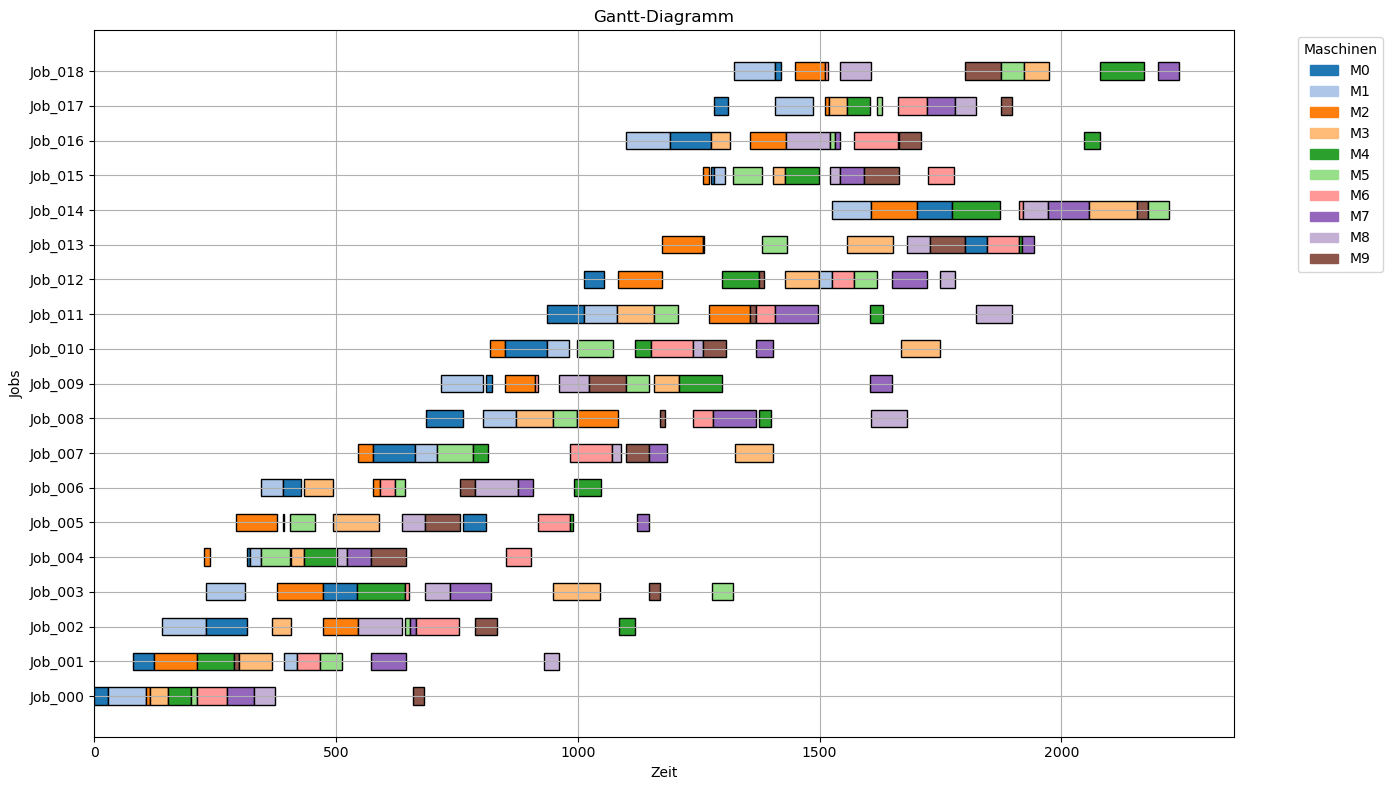

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [30]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [34]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 60, steps= 30)

label
<-60          0
-60 - -30     1
-30 - 0       1
0            17
0 - 30        0
30 - 60       0
>60           0
Name: count, dtype: int32

In [24]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

## c) Summe der Lateness minimieren 
### (gewichtet Tardiness je Job und "Earliness" der ersten Op)

$$
\min \left(
    w_1 \cdot \sum_{j \in J} \max(0,\ C_{j,\text{last}} - d_j)
    +
    w_2 \cdot \sum_{j \in J} \max\left(0,\ d_j - (S_{j,\text{first}} + P_j) \right)
\right)
$$

**mit:**

- $J$: Menge aller Jobs  
- $C_{j,\text{last}}$: Endzeit der letzten Operation von Job $j$  
- $S_{j,\text{first}}$: Startzeit der ersten Operation von Job $j$  
- $d_j$: Deadline des Jobs  
- $P_j$: Gesamtdauer aller Operationen von Job $j$, also $P_j := \sum_{(j,o) \in O_j} p_{j,o}$  
- $w_1$, $w_2$: Gewichtungen für Tardiness und Earliness


In [ ]:
from ortools.sat.python import cp_model
import pandas as pd

# Hilfsfunktion zur Prüfung, ob überhaupt eine Lösung gefunden wurde
def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_by_tardiness_and_first_earliness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    w1: float = 5.0,     # Gewicht für Verspätung (Tardiness)
    w2: float = 1.0,     # Gewicht für Frühfertigkeit der ersten Operation
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:

    model = cp_model.CpModel()

    # OR-Tools CP-Solver verwendet nur Integer, daher Skalierung für Zielfunktion
    scale = 1
    w1_scaled = int(w1 * scale)
    w2_scaled = int(w2 * scale)

    # Ankunftszeiten und Deadlines vorbereiten
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Operationen gruppieren und Maschinen extrahieren
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # Grobe obere Grenze für Zeitvariablen
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    starts, ends, intervals = {}, {}, {}
    weighted_terms = []  # Bestandteile der Zielfunktion

    # Zeitvariablen und Intervalle für jede Operation
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Zielfunktion: Tardiness der letzten + Earliness der ersten Operation
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1

        # Tardiness der letzten Operation
        job_end = ends[(j, last_op_index)]
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_last_{j}")
        tardiness = model.NewIntVar(0, horizon, f"tardiness_last_{j}")
        model.Add(lateness == job_end - deadline[job])
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w1_scaled, f"term_tardiness_{j}")
        model.Add(term_tardiness == w1_scaled * tardiness)
        weighted_terms.append(term_tardiness)

        # Frühfertigkeit bezogen auf: d_j - (S_{j,first} + P_j), wobei P_j = Summe aller Bearbeitungszeiten des Jobs
        if last_op_index >= 1:
            st = starts[(j, 0)]  # Startzeit der ersten Operation
            P_j = sum(d for (_, _, d) in all_ops[j])  # Gesamte Bearbeitungszeit des Jobs
        
            end_first_plus_total = model.NewIntVar(0, horizon, f"end_first_plus_total_{j}")
            model.Add(end_first_plus_total == st + P_j)
        
            earliness_expr = model.NewIntVar(-horizon, horizon, f"earliness_expr_{j}")
            model.Add(earliness_expr == deadline[job] - end_first_plus_total)
        
            earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
            model.AddMaxEquality(earliness, [earliness_expr, 0])
        
            term_earliness = model.NewIntVar(0, horizon * w2_scaled, f"term_earliness_{j}")
            model.Add(term_earliness == w2_scaled * earliness)
        
            weighted_terms.append(term_earliness)

    # Technologische Reihenfolge (Operationen nacheinander)
    for j in range(len(jobs)):
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])
        # Ankunftszeit berücksichtigen
        model.Add(starts[(j, 0)] >= arrival[jobs[j]])

    # Maschinenbelegung: keine Überlappungen
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (iv, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion minimieren
    model.Minimize(sum(weighted_terms))

    # Solver-Einstellungen und Start
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # Lösung extrahieren
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE] and has_solution(solver, next(iter(starts.values()))):
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d

                # Berechne Lateness etc. für Ausgabe
                lateness = ed - deadline[job]
                tardiness = max(0, lateness)
                earliness = max(0, -lateness)

                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness,
                    "Tardiness": tardiness,
                    "Earliness": earliness
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print("No feasible solution found.")
        df_schedule = pd.DataFrame()

    # Zusammenfassung ausgeben
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    if not df_schedule.empty:
        print(f"Objective Value       : {solver.ObjectiveValue() / scale:.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound() / scale:.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule

In [ ]:
starting_time = time.time()

# Aufruf der gewichteten Zielfunktion: Tardiness für letzte Operation, Earliness für alle vorherigen
df_plan = solve_cp_jssp_by_tardiness_and_first_earliness(
    df_jssp, df_times,
    w1=200,    # Gewicht für Tardiness (letzte Operation)
    w2=1,      # Gewicht für Earliness (erste Operation)
    msg=False,
    timeLimit=45,
    gapRel=0.10
)

ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

In [ ]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [ ]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 30)